In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk

import sys
sys.path.append('../')
from datasets.hecktor_petct_dataset import HECKTORPETCTDataset
from datautils.preprocessing import Preprocessor
from datautils.patch_sampling import PatchSampler3D, PatchQueue, get_num_valid_patches
from datautils.patch_aggregation import PatchAggregator3D
from datautils.visualization import NdimageVisualizer
from datautils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crS_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

viz = NdimageVisualizer()

In [3]:
def volumetric_dice(label_volume_1, label_volume_2):
    intersection = np.sum(label_volume_1 * label_volume_2)
    dice_score = 2 * intersection / (np.sum(label_volume_1) + np.sum(label_volume_2))
    return dice_score

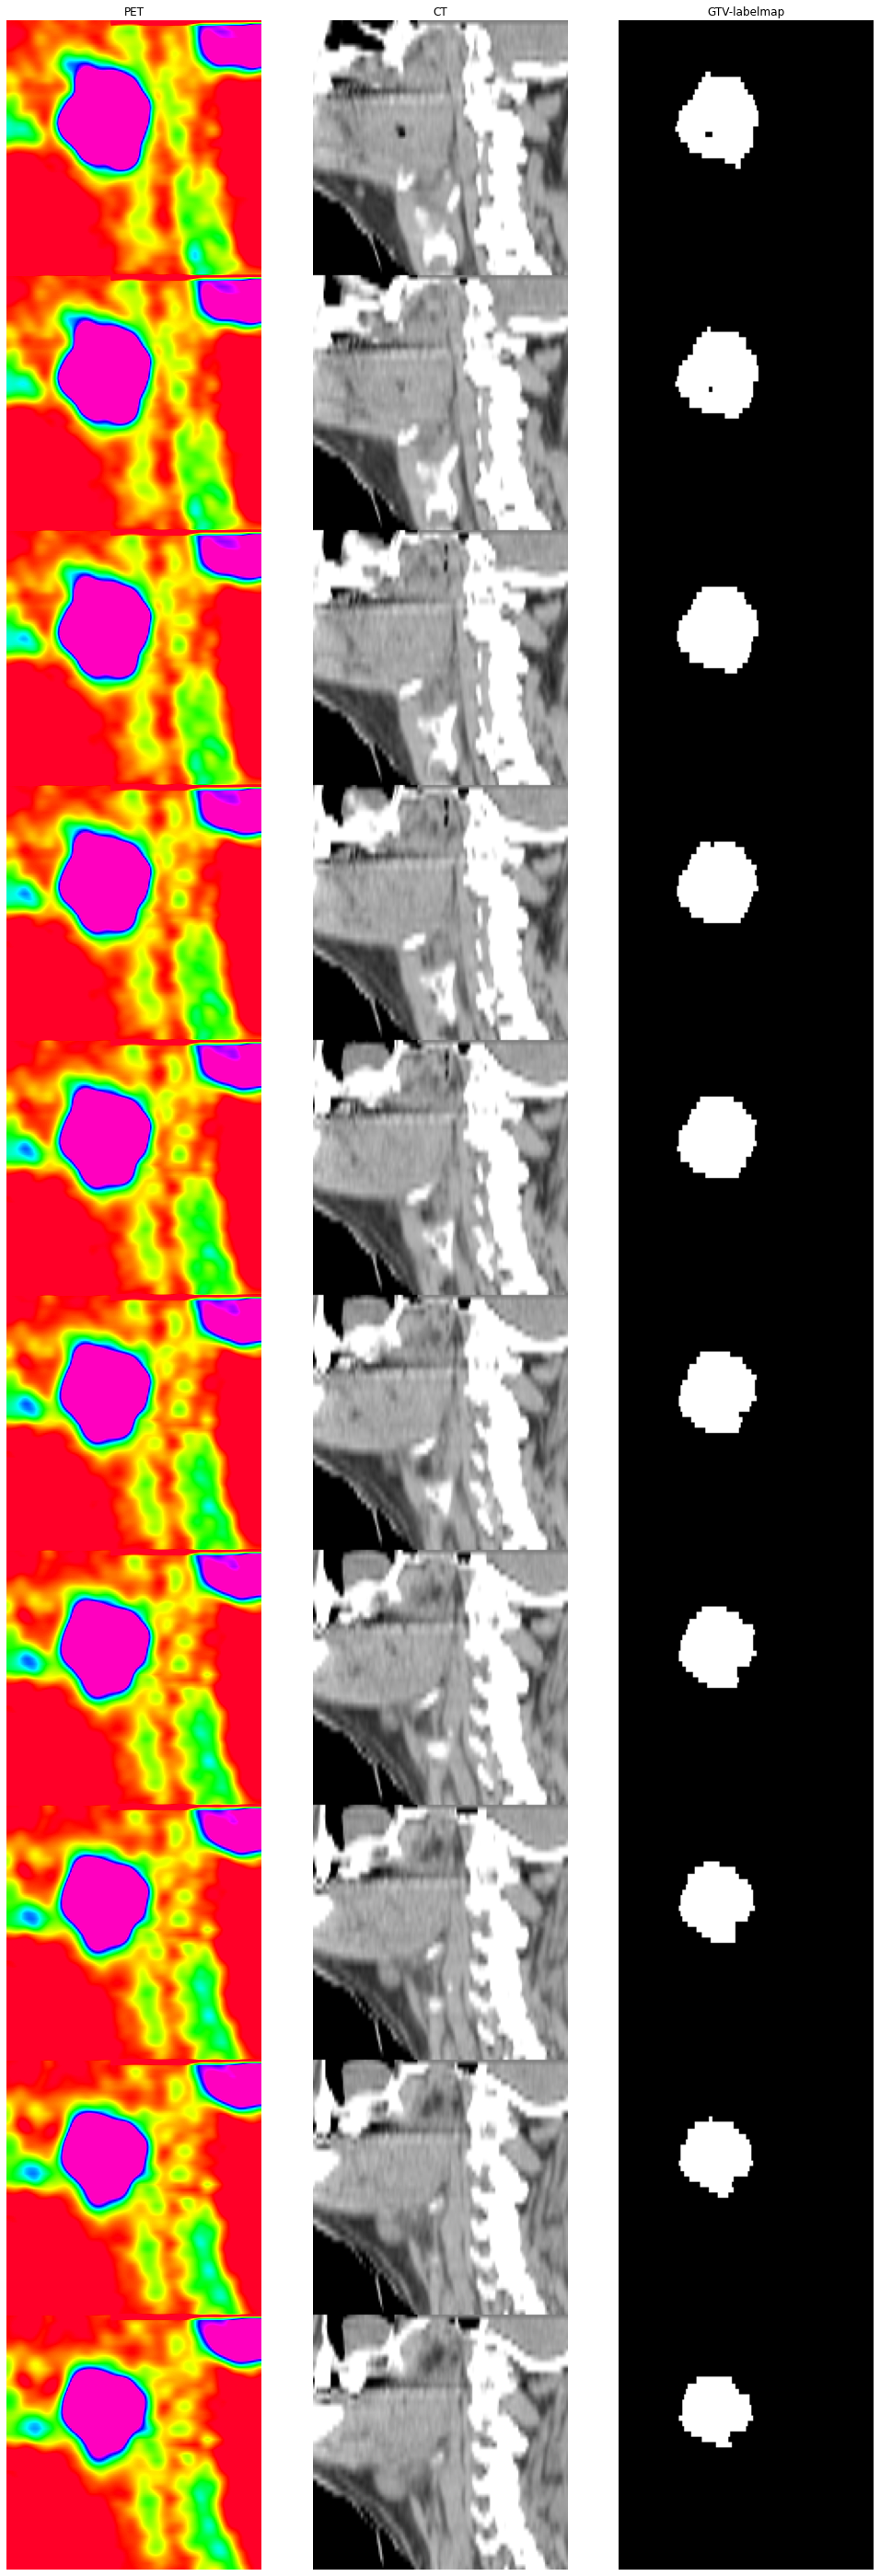

In [4]:
sample_idx = 0

PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training', 
                                     preprocessor=Preprocessor(),
                                     input_representation='separate-volumes', 
                                     augment_data=False)

patient_dict = PET_CT_dataset[sample_idx]

# Keep (D,H,W) ordering
PET_np = patient_dict['PET'].squeeze().numpy()
CT_np = patient_dict['CT'].squeeze().numpy()
GTV_labelmap_np = patient_dict['GTV-labelmap'].squeeze().numpy()


# Display input-target pair slices
viz.multi_image_strips([dhw2whd(PET_np), dhw2whd(CT_np), dhw2whd(GTV_labelmap_np)],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[90, 100],
                          view='sagittal',
                          subtitles=[])

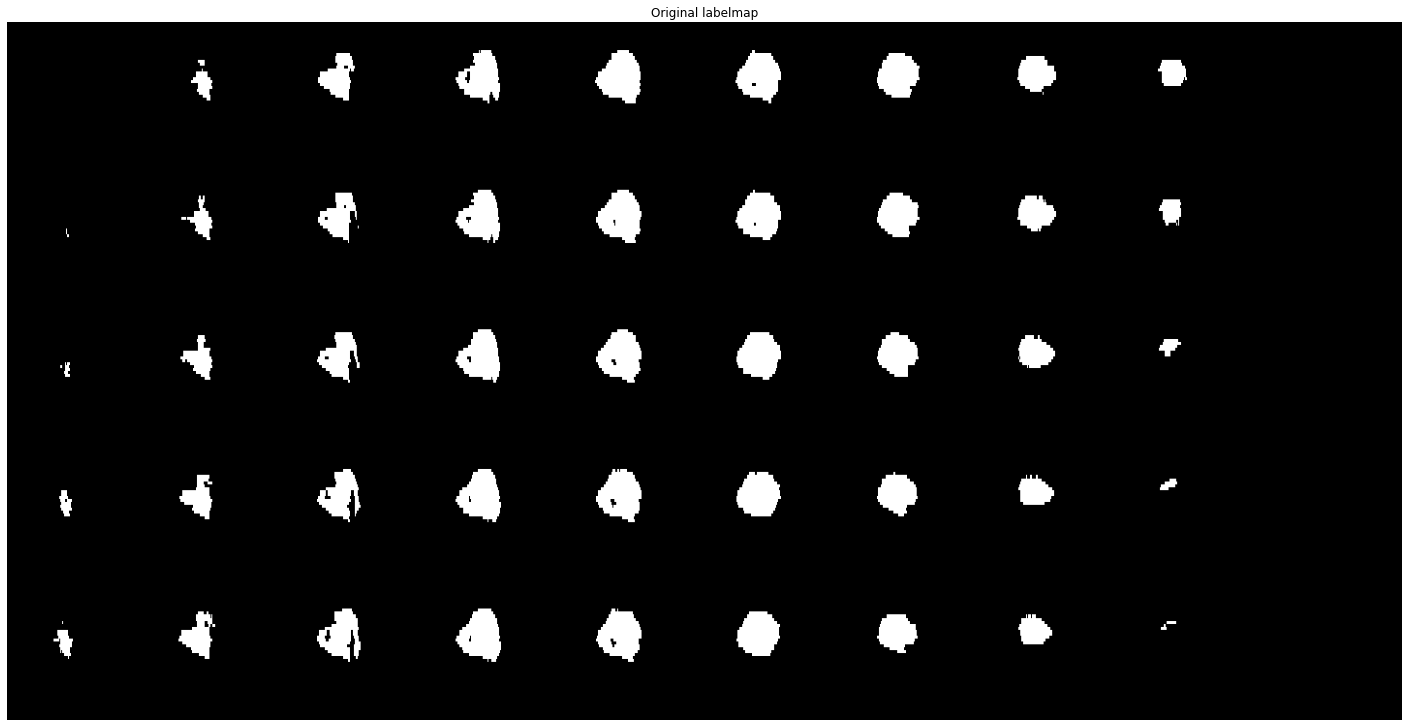

In [5]:
# Display the GTV labelmap

viz.grid(dhw2whd(GTV_labelmap_np), 
         idx_range=[65,112], 
         view='sagittal', 
         modality='GTV-labelmap', 
         title='Original labelmap')

## 1 Simple patch sampling and aggregation test

### Extract all valid patches from the volume

No. of patches: 8


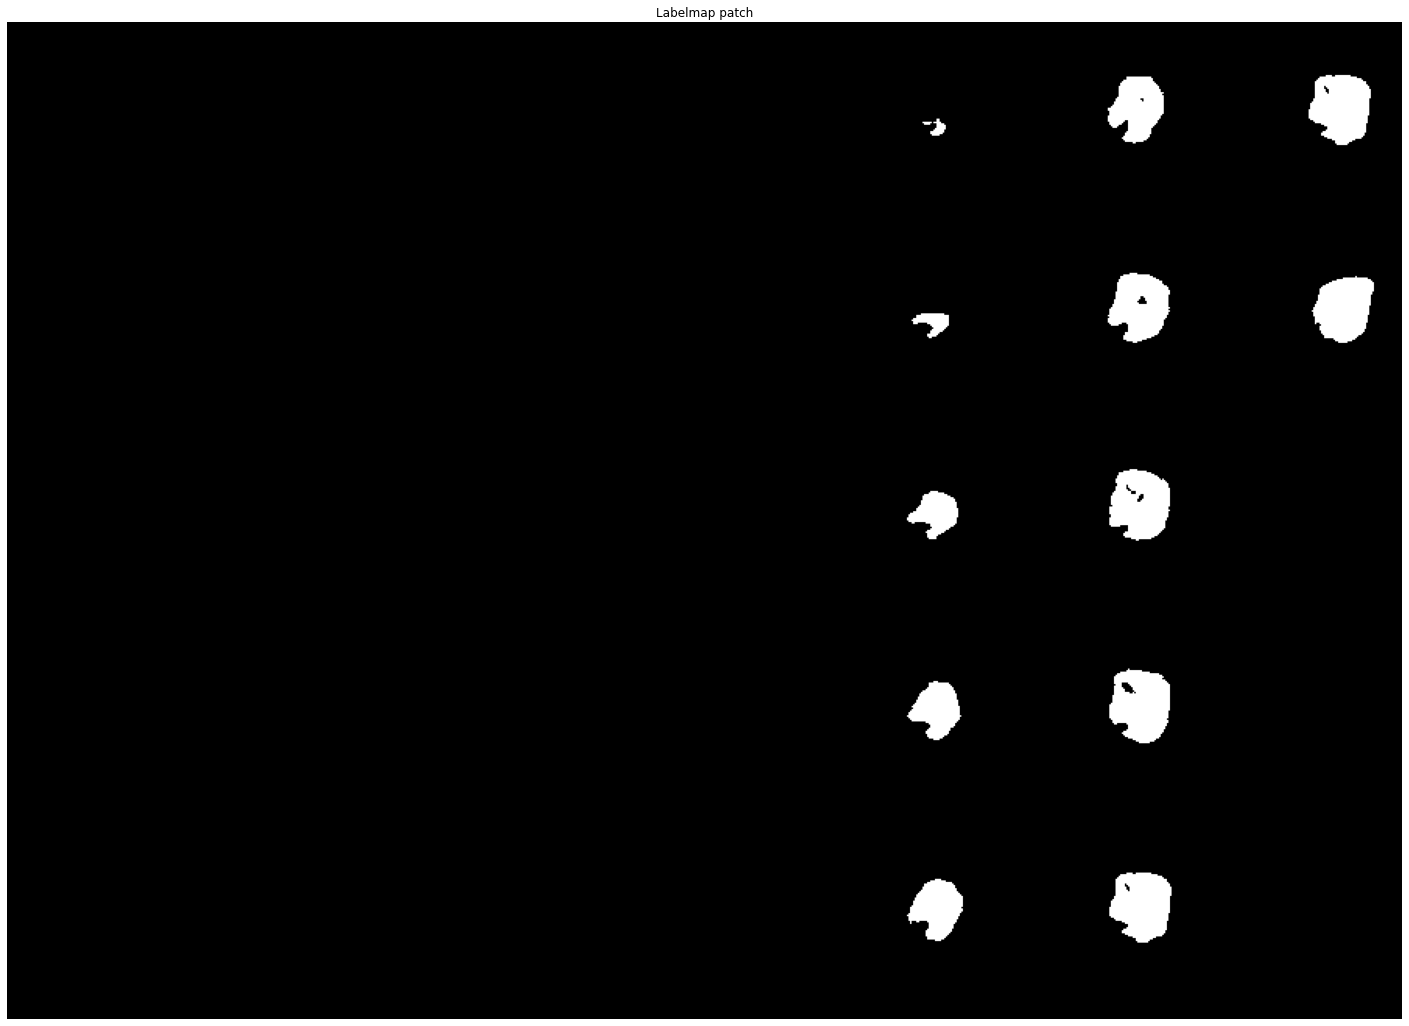

In [6]:
volume_size = (144,144,48)
patch_size = (128,128,32)
focal_point_stride = (10,10,10)

patch_sampler = PatchSampler3D(patch_size, 
                               volume_size,
                               sampling='sequential',
                               focal_point_stride=focal_point_stride)

num_valid_patches = get_num_valid_patches(patch_size, volume_size, focal_point_stride)
patches_list = patch_sampler.get_samples(patient_dict, num_patches=num_valid_patches)
print("No. of patches:", len(patches_list))

# Display 1st GTV labelmap patch
GTV_labelmap_patch = patches_list[0]['GTV-labelmap'].numpy()

viz.grid(dhw2whd(GTV_labelmap_patch), 
         idx_range=[0,32], 
         view='axial', 
         modality='GTV-labelmap', 
         title='Labelmap patch')

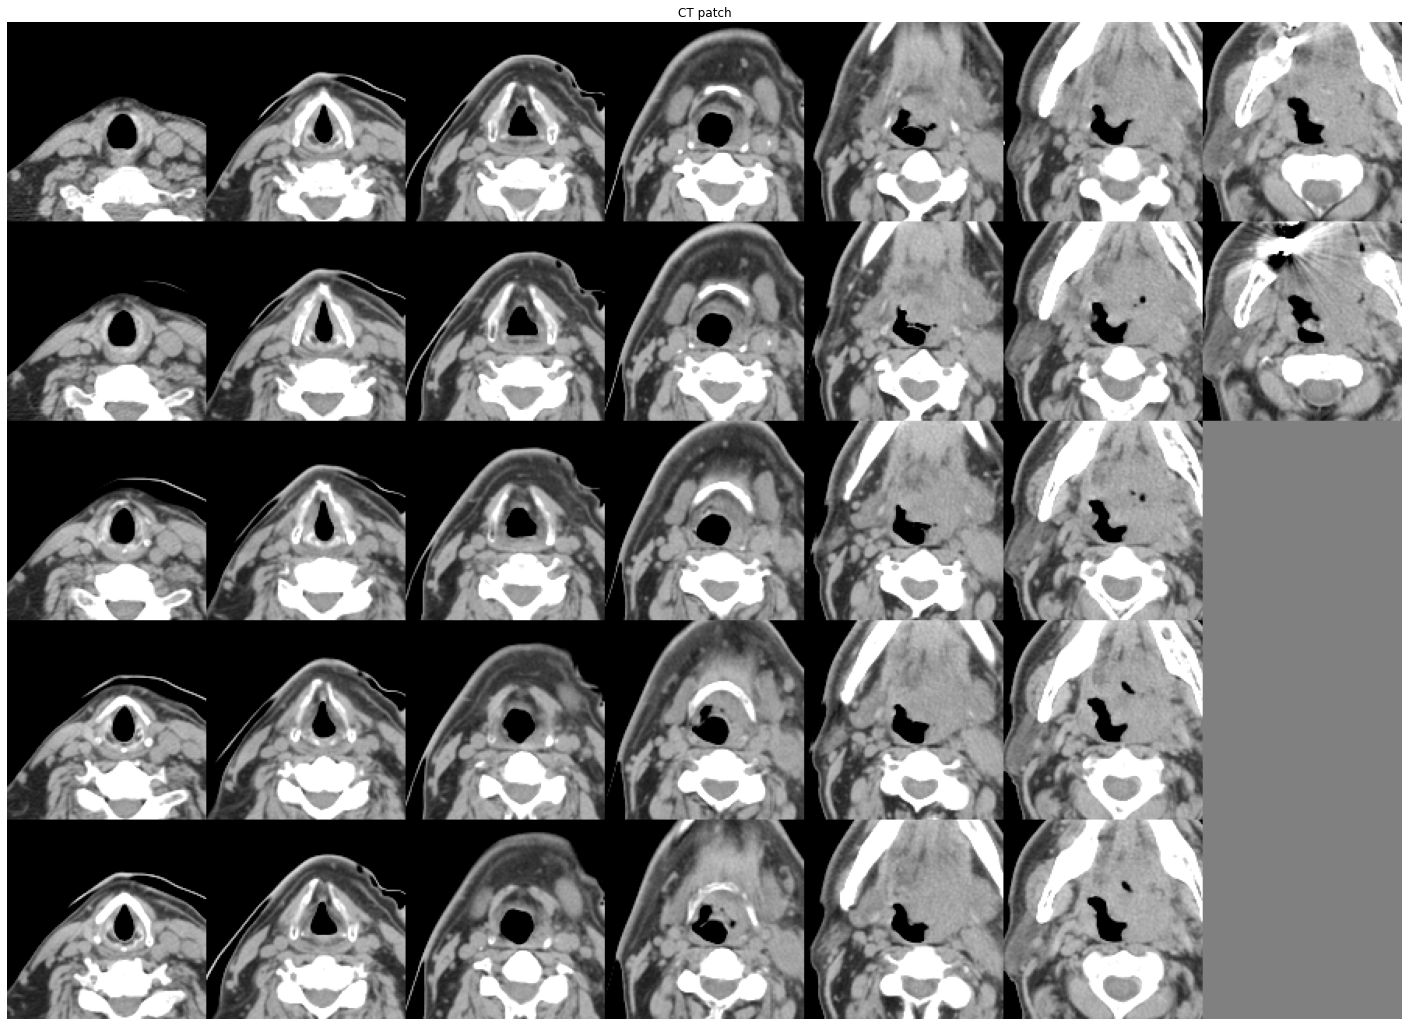

In [7]:
# Display 1st CT labelmap patch
CT_patch = patches_list[0]['CT'].squeeze().numpy()

viz.grid(dhw2whd(CT_patch), 
         idx_range=[0,32], 
         view='axial', 
         modality='CT', 
         title='CT patch')

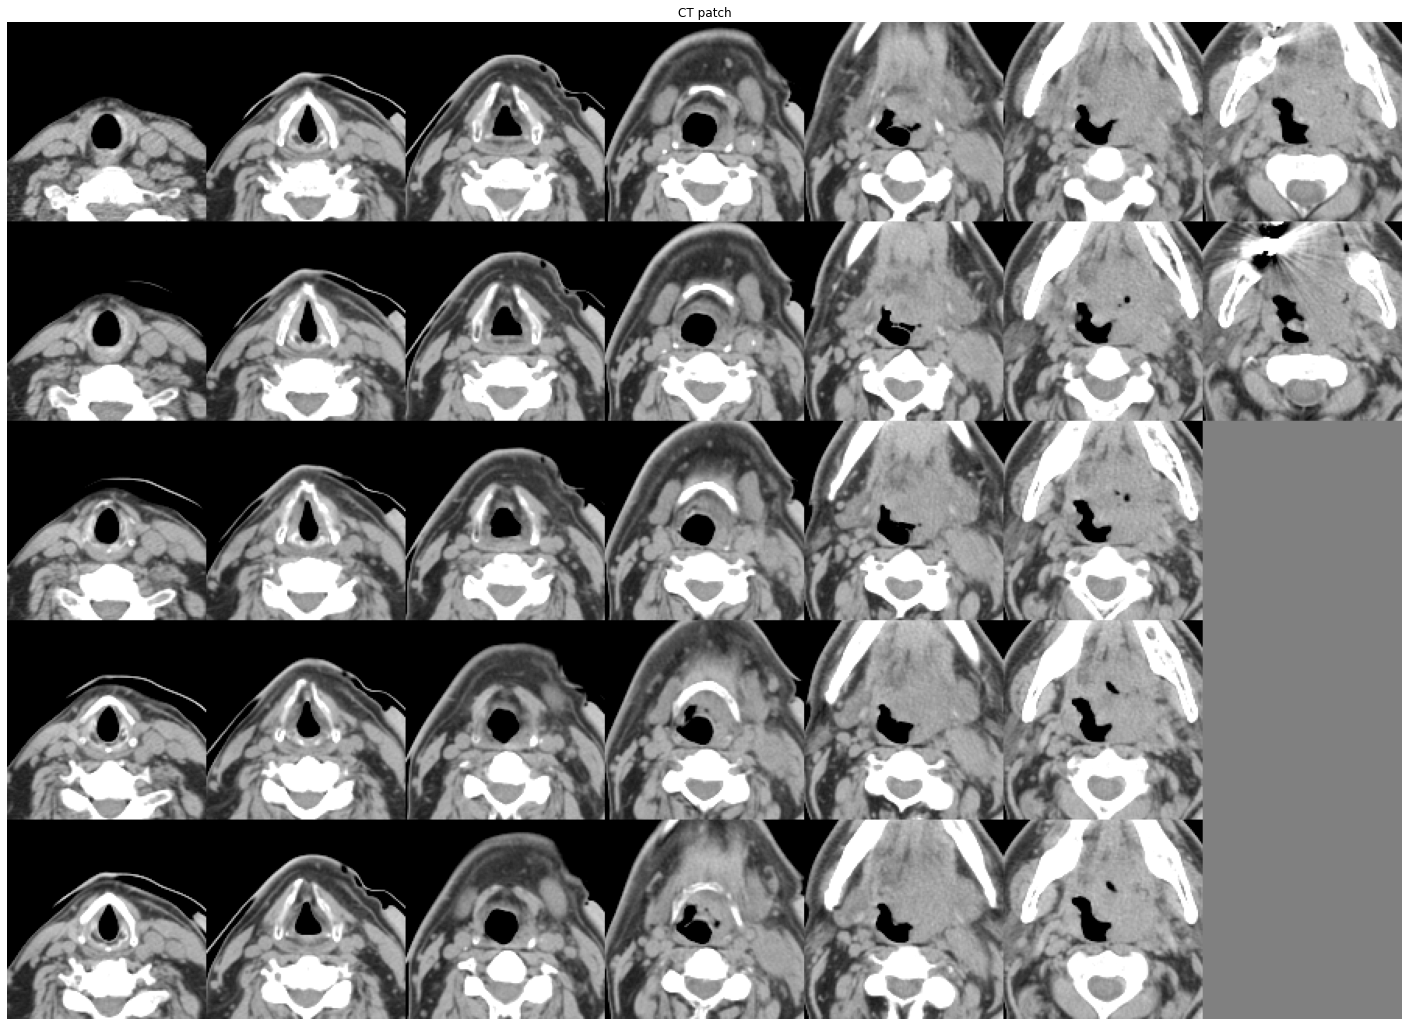

In [8]:
# Display 2nd CT patch
CT_patch = patches_list[1]['CT'].squeeze().numpy()

viz.grid(dhw2whd(CT_patch), 
         idx_range=[0,32], 
         view='axial', 
         modality='CT', 
         title='CT patch')

### Aggregate the GTV labelmap patches and compare the volume with the original

torch.Size([32, 128, 128])
torch.Size([48, 144, 144])


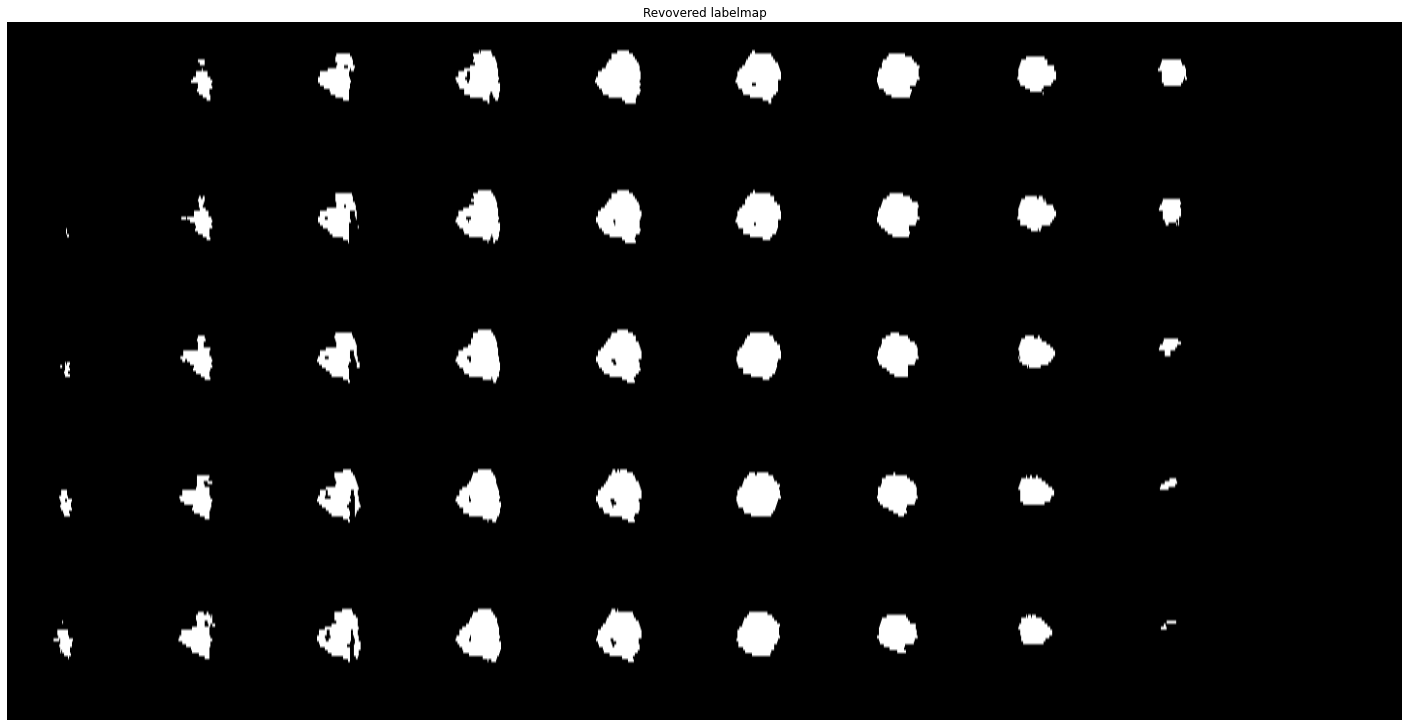

In [9]:
patch_aggregator = PatchAggregator3D(patch_size, 
                                     volume_size, 
                                     focal_point_stride, 
                                     overlap_handling='union')

labelmap_patches_list = [patch['GTV-labelmap'] for patch in patches_list]
print(labelmap_patches_list[0].shape)

recovered_labelmap = patch_aggregator.aggregate(labelmap_patches_list)
print(recovered_labelmap.shape)

# Display the recovered GTV labelmap
viz.grid(dhw2whd(recovered_labelmap), 
         idx_range=[65,112], 
         view='sagittal',
         modality='GTV-labelmap', 
         title='Revovered labelmap')

In [10]:
# Quantify the similarity

print(volumetric_dice(recovered_labelmap.numpy(), GTV_labelmap_np))

1.0


## 2 Padding test

In [11]:
volume_size = (144,144,48)
patch_size = (128,128,32)

focal_point_stride = (60,60,20) # Larger and uneven focal stride
padding = (44,44,4)  # Uneve padding to compensate, so that same number of patches are created (i.e. 8)

In [12]:
# Get patches using the sampler
patch_sampler = PatchSampler3D(patch_size, 
                               volume_size,
                               sampling='sequential',
                               focal_point_stride=focal_point_stride,
                              padding=padding)

num_valid_patches = get_num_valid_patches(patch_size, volume_size, focal_point_stride, padding=padding)
patches_list = patch_sampler.get_samples(patient_dict, num_patches=num_valid_patches)
print("No. of patches:", len(patches_list))


No. of patches: 8


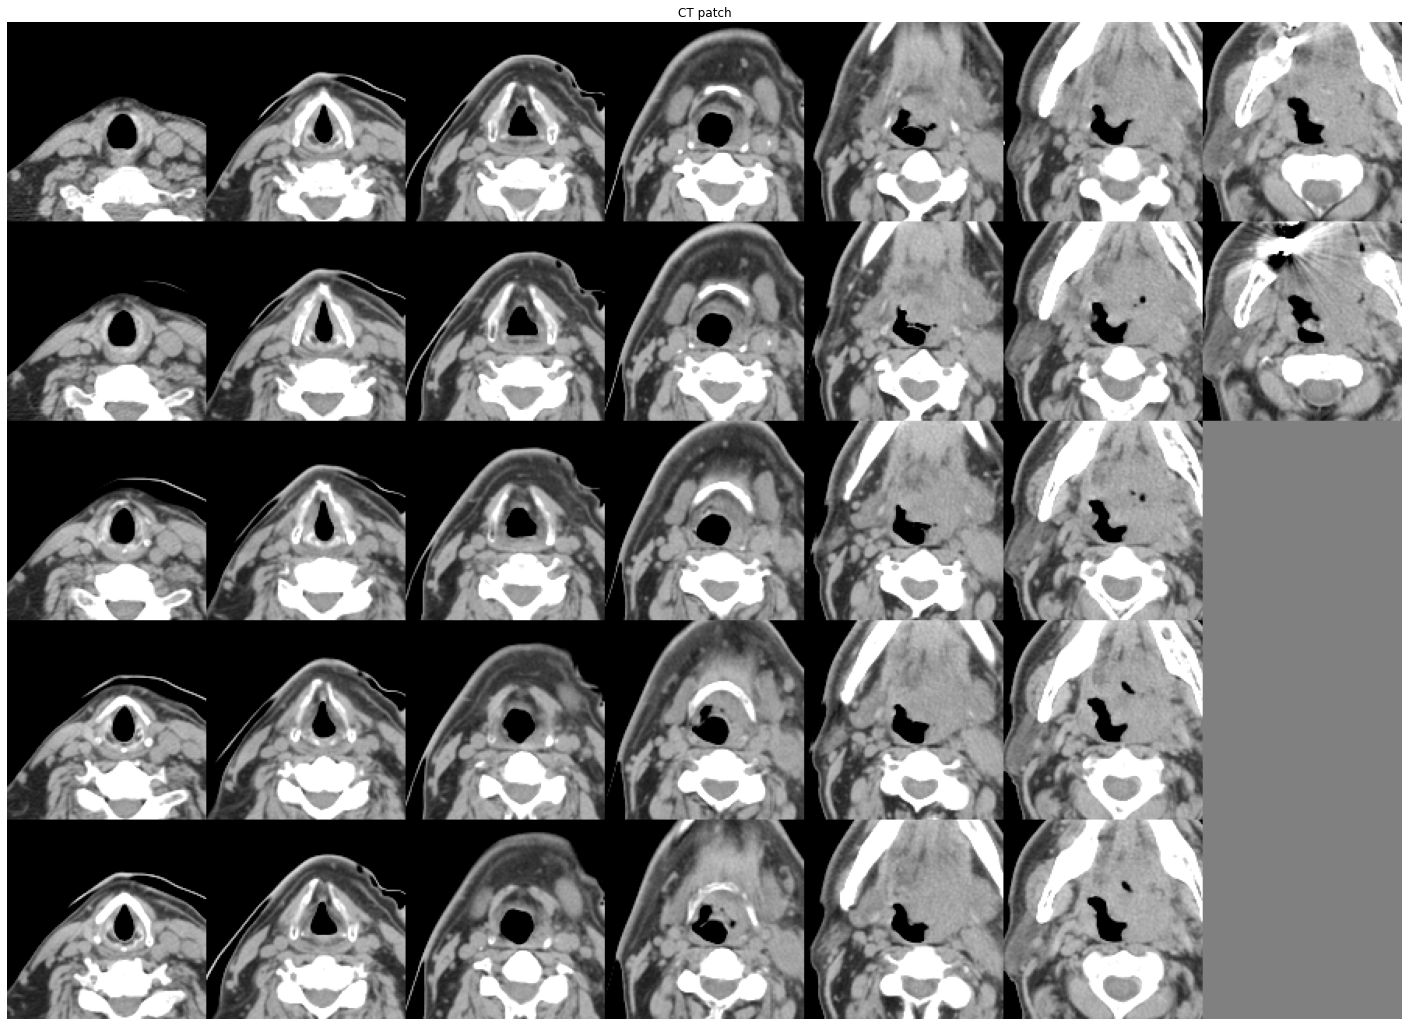

In [13]:
# Display 1st GTV labelmap patch
CT_patch = patches_list[0]['CT'].squeeze().numpy()

viz.grid(dhw2whd(CT_patch), 
         idx_range=[0,32], 
         view='axial', 
         modality='CT', 
         title='CT patch')


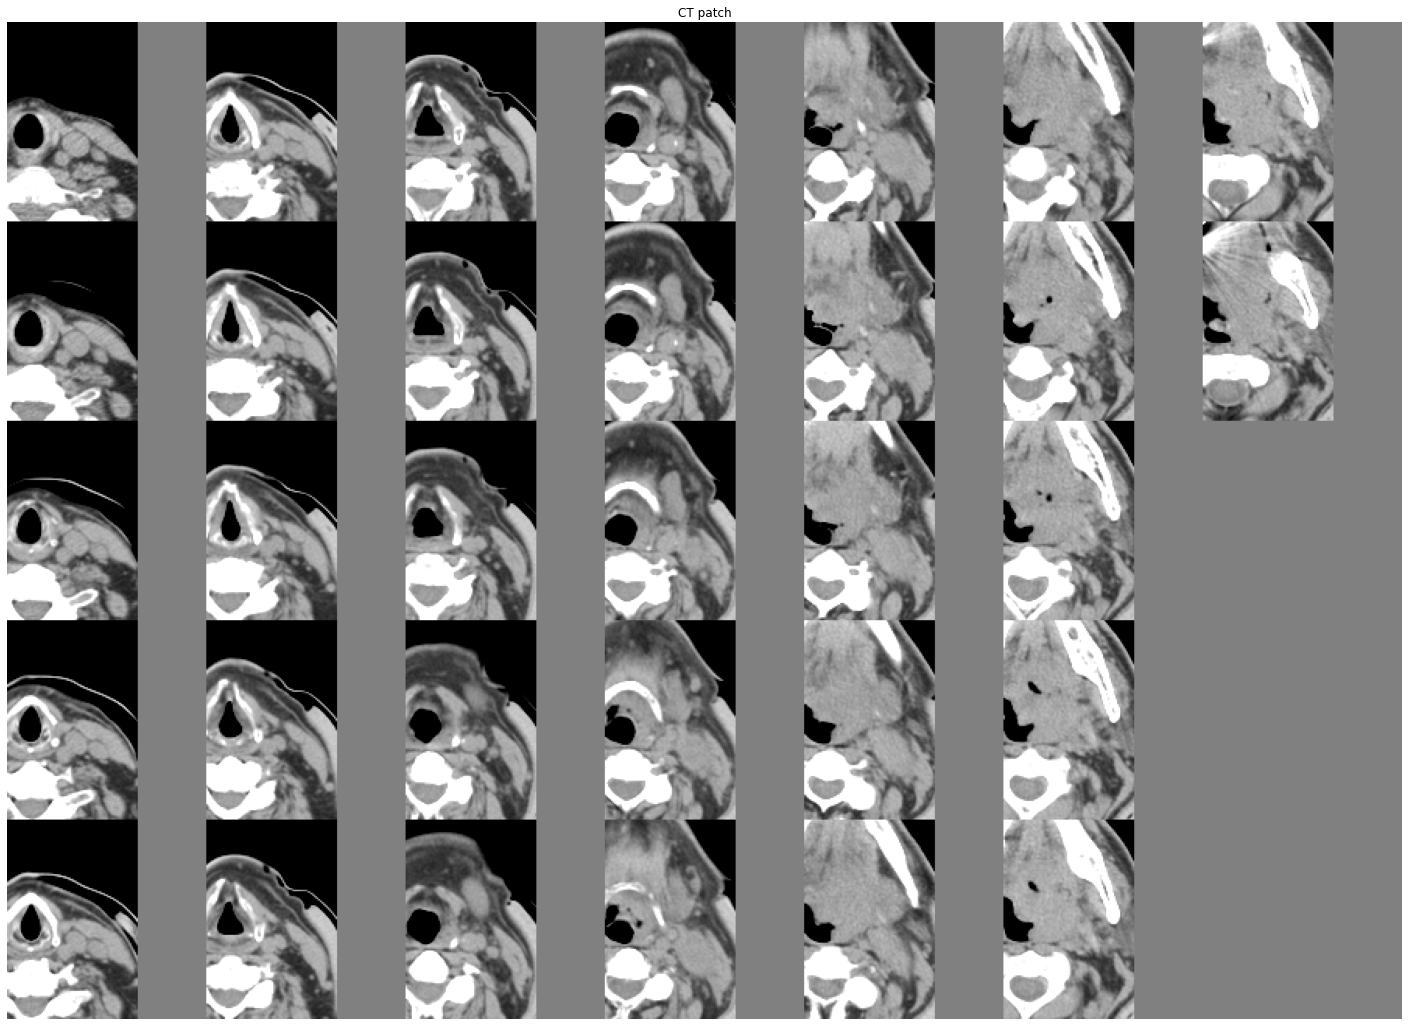

In [14]:
# Display 2nd GTV labelmap patch
CT_patch = patches_list[1]['CT'].squeeze().numpy()

viz.grid(dhw2whd(CT_patch), 
         idx_range=[0,32], 
         view='axial', 
         modality='CT', 
         title='CT patch')

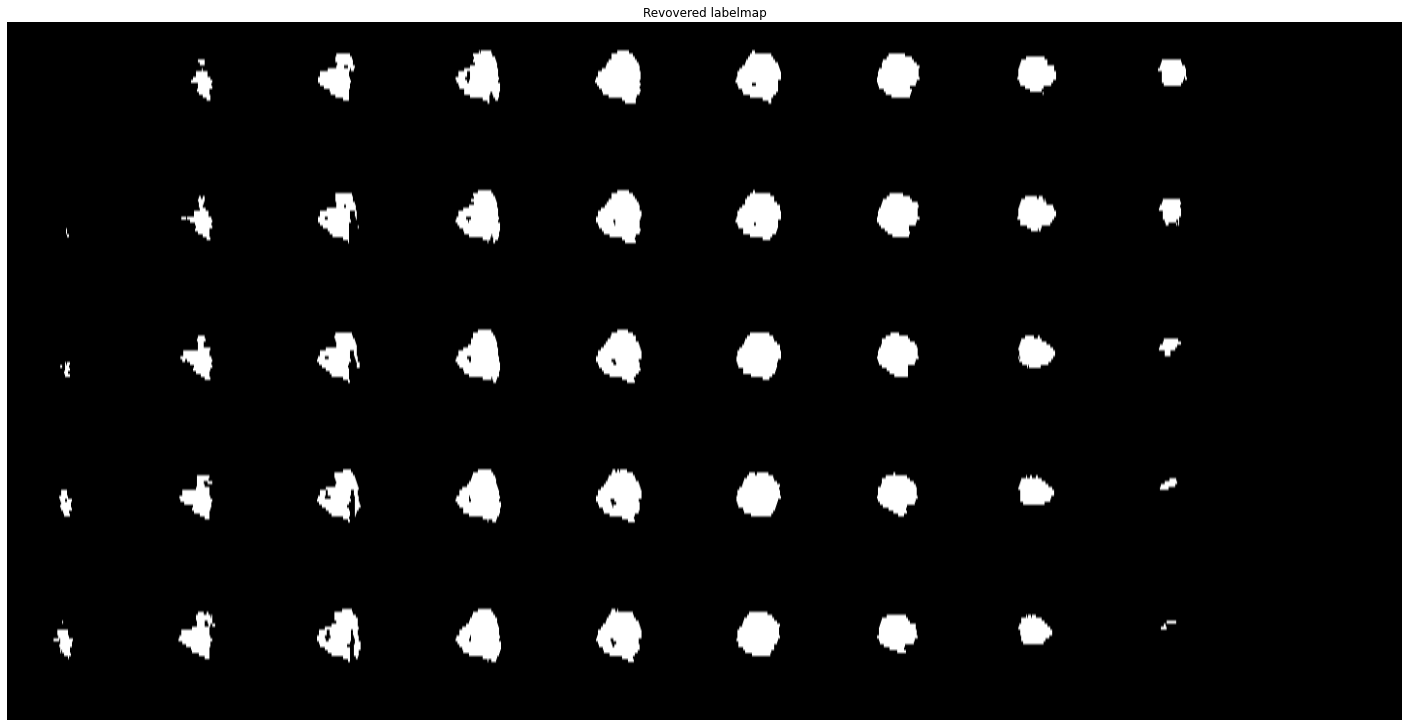

In [15]:
# Aggregate the GTV patches
patch_aggregator = PatchAggregator3D(patch_size, 
                                     volume_size, 
                                     focal_point_stride, 
                                     overlap_handling='union',
                                     unpadding=padding)

labelmap_patches_list = [patch['GTV-labelmap'] for patch in patches_list]

recovered_labelmap = patch_aggregator.aggregate(labelmap_patches_list)

# Display the recovered GTV labelmap
viz.grid(dhw2whd(recovered_labelmap), 
         idx_range=[65,112], 
         view='sagittal',
         modality='GTV-labelmap', 
         title='Revovered labelmap')

In [16]:
# Quantitative similarity check

print(volumetric_dice(recovered_labelmap.numpy(), GTV_labelmap_np))

1.0
